## Analyzing NSL-KDD

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline

2024-11-21 17:19:10.913423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732202350.939733   13924 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732202350.948604   13924 cuda_blas.cc:1410] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 17:19:10.977923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data Exploration

## 1.1. Load data

In [2]:
train = pd.read_csv("data/NSL_KDD/csv/Train20.csv")
train = train.drop(['Unnamed: 0'], axis=1)
train.name = "Train"
test = pd.read_csv("data/NSL_KDD/csv/Test.csv")
test = test.drop(['Unnamed: 0'], axis=1)
test.name = "Test"

In [3]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [4]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,probe


In [100]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [101]:
test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [8]:
train["class"].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy'], dtype=object)

In [9]:
train["target"].unique()

array([20, 15, 19, 21, 18, 17, 16, 12, 14, 11,  2, 13, 10,  9,  8,  7,  3,
        5,  1,  6,  0,  4])

In [10]:
train[["class", "target", "Attack Type"]]

,class,target,Attack Type
0,normal,20,normal
1,normal,15,normal
2,neptune,19,dos
3,normal,21,normal
4,normal,21,normal
...,...,...,...
25187,neptune,19,dos
25188,warezclient,12,r2l
25189,neptune,21,dos
25190,neptune,20,dos


In [64]:
def piePlot(df, columns_list, rows, columns):
    fig, axes = plt.subplots(rows, columns)
    for ax, col in zip(axes.ravel(), columns_list):
        labels = np.full((1,len(df[col].unique())),'')
        df[col].value_counts().plot(ax=ax,
                                    kind='pie',
                                    labels=labels[0],
                                    figsize=(25,25),
                                    fontsize=10)
        ax.set_title(col)
        ax.legend(loc=3, labels=df[col].unique())

Train data plot

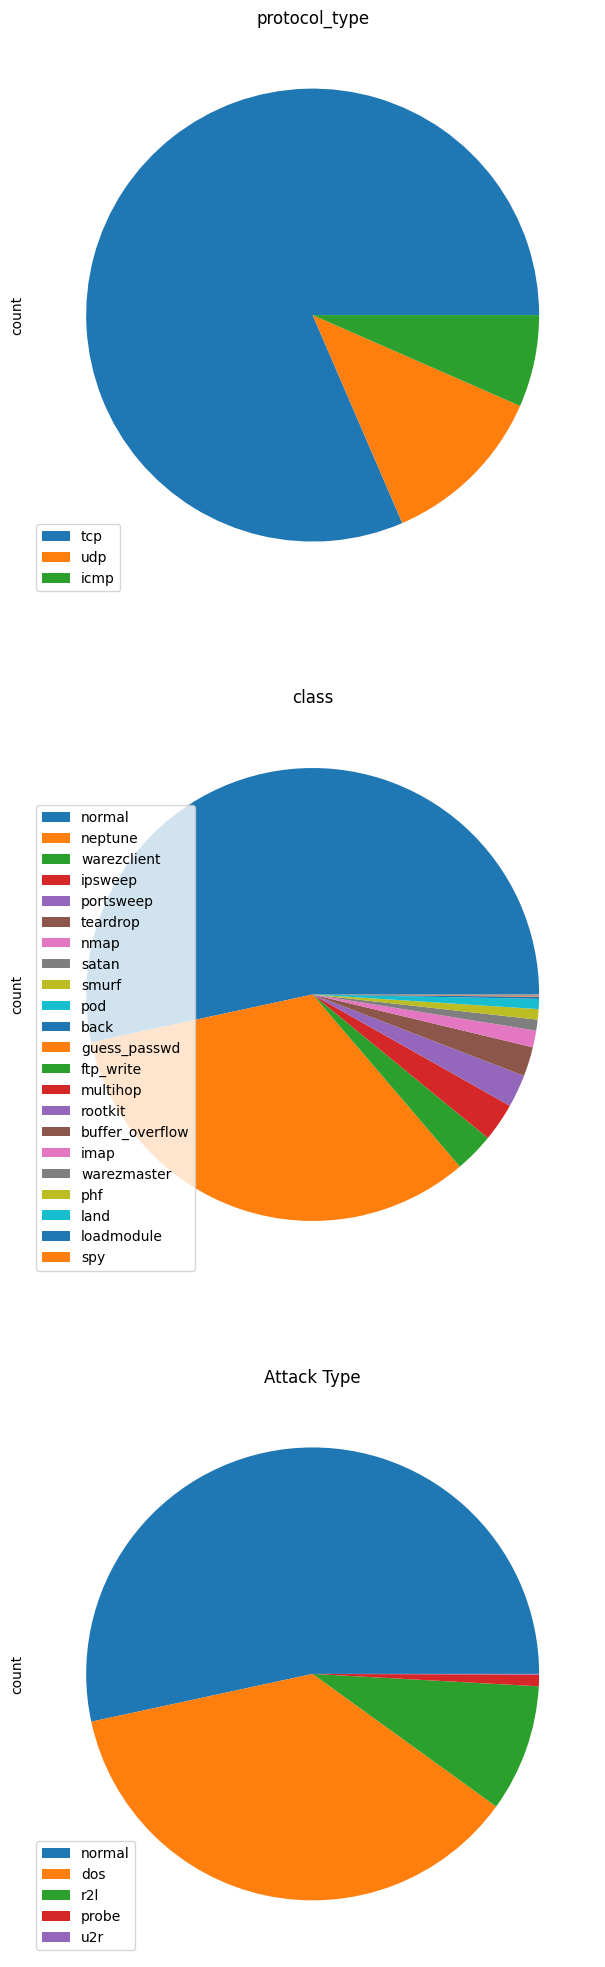

In [65]:
piePlot(train, ["protocol_type", "class", "Attack Type"], 3, 1)

Test data plot

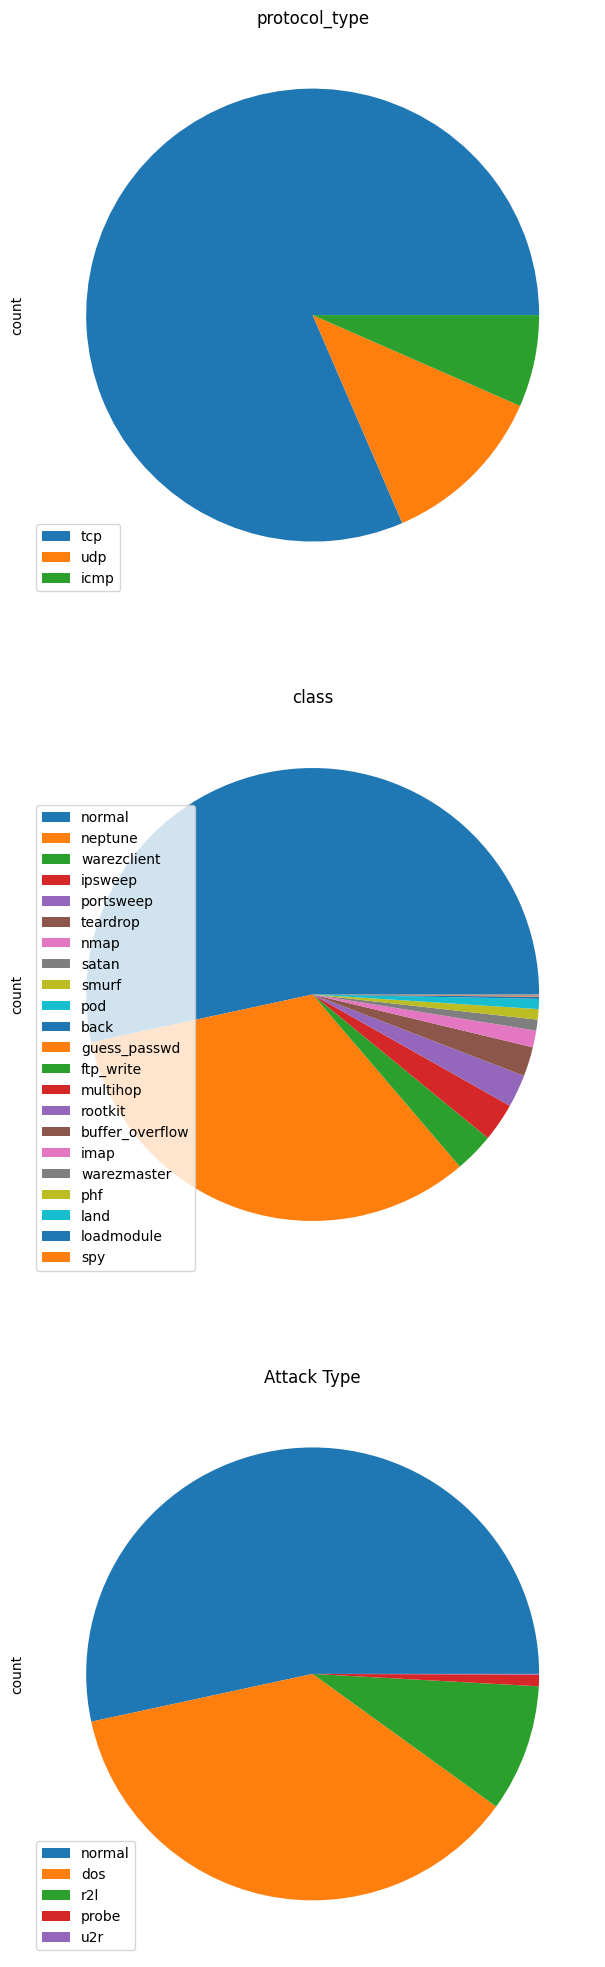

In [66]:
piePlot(train, ["protocol_type", "class", "Attack Type"], 3, 1)

In [12]:
def printColumns(df, column):
    values = df[column].unique()
    table = PrettyTable([f"{column} - {df.name}", "Count"])
    for value in values:
        count = df[column].loc[df[column]==value].count()
        table.add_row([f"{value}", f"{count}"])
    print(table)

In [13]:
datasets = [train, test]
columns = train.select_dtypes(include='object')

for dataset in datasets:
    for column in columns:
        printColumns(dataset, column)

+-----------------------+-------+
| protocol_type - Train | Count |
+-----------------------+-------+
|          tcp          | 20526 |
|          udp          |  3011 |
|          icmp         |  1655 |
+-----------------------+-------+
+-----------------+-------+
| service - Train | Count |
+-----------------+-------+
|     ftp_data    |  1396 |
|      other      |  858  |
|     private     |  4351 |
|       http      |  8003 |
|    remote_job   |   17  |
|       name      |   92  |
|    netbios_ns   |   76  |
|      eco_i      |  909  |
|       mtp       |   90  |
|      telnet     |  483  |
|      finger     |  366  |
|     domain_u    |  1820 |
|      supdup     |  114  |
|    uucp_path    |  133  |
|      Z39_50     |  172  |
|       smtp      |  1449 |
|     csnet_ns    |  111  |
|       uucp      |  157  |
|   netbios_dgm   |   85  |
|      urp_i      |  124  |
|       auth      |  189  |
|      domain     |  109  |
|       ftp       |  345  |
|       bgp       |  146  |
|     

In [14]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

In [15]:
train["class"]

0             normal
1             normal
2            neptune
3             normal
4             normal
            ...     
25187        neptune
25188    warezclient
25189        neptune
25190        neptune
25191        neptune
Name: class, Length: 25192, dtype: object

In [16]:
test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'target', 'Attack Type'],
      dtype='object')

## 2. Data Preprocessing

In [4]:
data = pd.concat([train, test])
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,Attack Type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21,normal
22540,0,tcp,http,SF,317,938,0,0,0,0,...,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21,normal
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15,dos
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [5]:
data = data.drop(["class", "target"], axis=1)
data = data.reset_index()

In [6]:
X = data.drop(["Attack Type"], axis=1)
y = data["Attack Type"]

In [7]:
X.head()

,index,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,tcp,ftp_data,SF,491,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,1,0,udp,other,SF,146,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,2,0,tcp,private,S0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,3,0,tcp,http,SF,232,8153,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,4,0,tcp,http,SF,199,420,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
le = LabelEncoder()
y = le.fit_transform(y.to_numpy())

In [9]:
def encodeData(df, columns, encoder):
    encoded = encoder.fit_transform(df[columns])
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns))
    df_encoded = pd.concat([df, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(columns, axis=1)
    return df_encoded

In [10]:
onehotencoder = OneHotEncoder(sparse_output=False)
columns = X.select_dtypes(include='object').columns.tolist()
X = encodeData(X, columns, onehotencoder)

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X

array([[-1.72151299, -0.12134467, -0.00968927, ..., -0.07457327,
         0.77414671, -0.04935536],
       [-1.72136917, -0.12134467, -0.00988296, ..., -0.07457327,
         0.77414671, -0.04935536],
       [-1.72122535, -0.12134467, -0.00996493, ..., -0.07457327,
        -1.29174481, -0.04935536],
       ...,
       [ 1.52025005, -0.12134467,  0.02065486, ..., -0.07457327,
         0.77414671, -0.04935536],
       [ 1.52039387, -0.12134467, -0.00994135, ..., -0.07457327,
         0.77414671, -0.04935536],
       [ 1.52053768, -0.12134467, -0.00996493, ..., -0.07457327,
        -1.29174481, -0.04935536]])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((33271, 120), (33271,), (7304, 120), (7304,), (7161, 120), (7161,))

## 3. Creating models

Testing these models:
1. Random Forest
2. K Nearest Neighbour
3. Support Vector Machine
4. Reccurent Neural Networks
5. Self Organizing Map

### 3.1. Random Forest

In [22]:
clf = RandomForestClassifier()

In [29]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
predictions = clf.predict(X_test)

In [31]:
print(f"R2: {clf.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

R2: 84.81%
MSE: 2.2463343108504397
MAE: 0.3178327049294791


In [32]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [20]:
RF_search_space = {
    'n_estimators': range(10, 2000),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10, 100),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'n_jobs': [8]
}

In [23]:
random_search = RandomizedSearchCV(estimator=clf, param_distributions=RF_search_space, n_iter=1, cv=2, verbose=3)
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END bootstrap=False, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1608, n_jobs=8;, score=0.983 total time=   8.2s
[CV 2/2] END bootstrap=False, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1608, n_jobs=8;, score=0.986 total time=   8.0s


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(10, 100),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': range(2, 11),
                                        'n_estimators': range(10, 2000),
                                        'n_jobs': [8]},
                   verbose=3)

In [35]:
clf.set_params(**random_search.best_params_)

RandomForestClassifier(max_depth=43, max_features=None, min_samples_leaf=2,
                       min_samples_split=9, n_estimators=76)

In [36]:
random_search.best_params_

{'n_estimators': 76,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 43,
 'criterion': 'gini',
 'bootstrap': True}

In [37]:
random_search.best_score_

np.float64(0.8401232285890327)

In [34]:
RF_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': 100,
    'max_features': None,
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 2,
    'min_samples_split': 7,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 125,
    'n_jobs': 8,
    'oob_score': False,
    'random_state': None,
    'verbose': 1,
    'warm_start': False
}

In [35]:
clf.set_params(**RF_params)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"R2: {clf.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s


R2: 99.02%
MSE: 0.02778941488618908
MAE: 0.015779919005725458


[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:    0.0s finished


## 2. Reccurent Neural Networks

In [36]:
X_bak = X
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((33271, 120, 1), (33271,), (7304, 120, 1), (7304,), (7161, 120, 1), (7161,))

In [17]:
X = X_bak

In [18]:
X.shape

(47736, 120)

In [37]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],), kernel_initializer = "lecun_normal"))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732171476.499806    2972 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4713 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0                                                   , compute capability: 6.1
2024-11-21 08:44:36.745396: I external/local_xla/xla/service/llvm_ir/llvm_command_line_options.cc:50] XLA (re)initializing LLVM with options fingerprint: 10118604875320632863


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          30,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,037 (308.74 KB)

 Trainable params: 79,037 (308.74 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
%%time
model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9809 - loss: 0.0462 - val_accuracy: 0.9766 - val_loss: 0.0848
Epoch 2/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9811 - loss: 0.0484 - val_accuracy: 0.9760 - val_loss: 0.1108
Epoch 3/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9834 - loss: 0.0464 - val_accuracy: 0.9754 - val_loss: 0.0917
Epoch 4/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9827 - loss: 0.0444 - val_accuracy: 0.9785 - val_loss: 0.0944
Epoch 5/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9835 - loss: 0.0452 - val_accuracy: 0.9775 - val_loss: 0.0938
Epoch 6/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9829 - loss: 0.0409 - val_accuracy: 0.9704 - val_loss: 0.0836
Epoch 7/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9832 - loss: 0.0395 - val_accuracy: 0.9771 - val_loss: 0.1008
Epoch 8/20
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9850 - loss: 0.0380 - 

In [42]:
_, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.1057
Accuracy: 97.78%


## 3.3. Linear Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40575, 120), (40575,), (7161, 120), (7161,))

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)
print(f"R2: {lin_reg.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

R2: 76.36%
MSE: 0.1722341302487318
MAE: 0.25321473677335377


## 3.4 XGBoost

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40575, 120), (40575,), (7161, 120), (7161,))

In [16]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
xgb_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [20]:
predictions = xgb_model.predict(X_test)

In [21]:
print(f"R2: {xgb_model.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

R2: 99.27%
MSE: 0.021505376344086023
MAE: 0.012009495880463622


In [23]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc.score(X_train, y_train)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9550462107208872

In [24]:
predictions = svc.predict(X_test)

In [25]:
print(f"R2: {svc.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

R2: 95.45%
MSE: 0.11087836894288507
MAE: 0.06675045384722804


In [26]:
svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [29]:
kNN_clf = KNeighborsClassifier()
kNN_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
predictions = kNN_clf.predict(X_test)

In [32]:
print(f"R2: {kNN_clf.score(X_test, y_test)*100:.2f}%\n\
MSE: {mean_squared_error(y_test, predictions)}\n\
MAE: {mean_absolute_error(y_test, predictions)}")

R2: 97.65%
MSE: 0.07177768468091049
MAE: 0.039100684261974585


In [34]:
confusion_matrix(predictions, y_test)

array([[2497,   13,   19,    3,    0],
       [   4, 3396,   16,   41,    0],
       [   1,   23,  664,    1,    0],
       [   0,   41,    0,  411,    4],
       [   0,    2,    0,    0,   25]])